In [1]:
import os 
import h5py 
import numpy as np 
from astropy.io import fits 
from astropy.cosmology import FlatLambdaCDM
import nbodykit.lab as nblab 

In [2]:
# -- pyspectrum -- 
from pyspectrum import util as UT 
from pyspectrum import pyspectrum as pySpec

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = os.path.join(os.environ['HOME'], 'data/pyspectrum/lowz/')

# compute bispectrum for CMASS LOWZ

In [5]:
# read lowz galaxy and random catalogs 
gals = np.loadtxt(os.path.join(dat_dir, 'gals.lowz.dat'), unpack=True) 
rand = np.loadtxt(os.path.join(dat_dir, 'rand.lowz.dat'), unpack=True) 

In [6]:
Ng = gals.shape[1] # number of galaxies 
Nr = rand.shape[1] # number of randoms

In [7]:
# galaxies
radecz_g = np.zeros((3, Ng))
radecz_g[0,:] = gals[0]
radecz_g[1,:] = gals[1]
radecz_g[2,:] = gals[2]
nbar_g = gals[3]
w_g = gals[4]

# randoms 
radecz_r = np.zeros((3, Nr))
radecz_r[0,:] = rand[0]
radecz_r[1,:] = rand[1]
radecz_r[2,:] = rand[2]
nbar_r = rand[3] 
w_r = np.ones(Nr) 

In [8]:
cosmo = FlatLambdaCDM(H0=67.6, Om0=0.31)  

bisp = pySpec.B0_survey(radecz_g, nbar_g, w=w_g, radecz_r=radecz_r,
        nbar_r=nbar_r, w_r=w_r, P0_fkp=1e5, Lbox=3600., Ngrid=360, step=3, Ncut=3,
        Nmax=40, fft='pyfftw', nthreads=1, cosmo=cosmo, silent=False)

--- 113525 positions in 3600 box ---
--- calculating the FFT for data ---
['311.1 < x < 1153.5\n', '-779.5 < y < 809.3\n', '-210.8 < z < 673.5\n']
113525 positions
Ntot=117725.00
I12=1.30e+02
I13=5.71e+00
I22=3.73e-02
I23=1.46e-03
I33=4.22e-07
positions assigned to grid
delta_0(k) complete
--- calculating the FFT for random ---
['304.2 < x < 1154.5\n', '-787.6 < y < 815.2\n', '-219.6 < z < 680.8\n']
5549994 positions
Ntot=5549994.00
I12=5.68e+03
I13=2.15e+02
I22=1.63e+00
I23=5.46e-02
I33=1.58e-05
positions assigned to grid
delta_0(k) complete
alpha=2.121173e-02
--- calculating the bispectrum ---


In [9]:
kf = bisp['meta']['kf'] 
bisp['i_k1'] = bisp['i_k1'].astype(float) * kf
bisp['i_k2'] = bisp['i_k2'].astype(float) * kf 
bisp['i_k3'] = bisp['i_k3'].astype(float) * kf

# read bispectrum calculated using fortran code 

In [15]:
k1_f, k2_f, k3_f, p0k1_f, b123_f, count_f = np.loadtxt(os.path.join(dat_dir, 'bisp.lowz.fortran.dat'),
        unpack=True, usecols=[0,1,2,3,6,8])

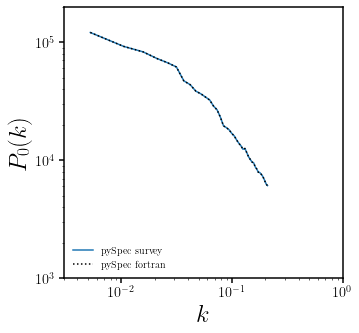

In [16]:
# compare powerspectrum 
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)

isort = np.argsort(bisp['i_k1'])
sub.plot(bisp['i_k1'][isort], bisp['p0k1'][isort], c='C0', ls='-',
        label='pySpec survey')
isort = np.argsort(k1_f)
sub.plot(k1_f[isort]*kf, p0k1_f[isort], c='k', ls=':', 
        label='pySpec fortran')


sub.legend(loc='lower left', fontsize=10) 
sub.set_ylabel('$P_0(k)$', fontsize=25) 
sub.set_yscale('log') 
sub.set_ylim(1e3, 2e5)
sub.set_xlabel('$k$', fontsize=25) 
sub.set_xlim([3e-3, 1.]) 
sub.set_xscale('log') 

6350 triangle configurations


(0.0, 6350.0)

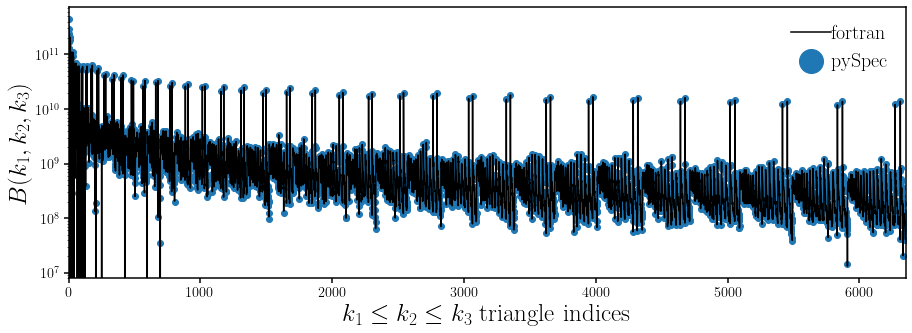

In [108]:
# compare output bispectrum 
i_k, j_k, l_k = bisp['i_k1'], bisp['i_k2'], bisp['i_k3']
klim = ((i_k <= 0.5) & (j_k <= 0.5) & (l_k <= 0.5)) 
print('%i triangle configurations' % np.sum(klim))

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(range(len(b123_f)), b123_f, c='k', label='fortran') 
sub.scatter(range(np.sum(klim)), bisp['b123'], c='C0', label='pySpec') 

sub.legend(loc='upper right', markerscale=4, handletextpad=0., fontsize=20) 
sub.set_ylabel('$B(k_1, k_2, k_3)$', fontsize=25) 
sub.set_yscale('log') 
#sub.set_ylim([1e8, 1e10]) 
sub.set_xlabel(r'$k_1 \le k_2 \le k_3$ triangle indices', fontsize=25) 
sub.set_xlim([0, np.sum(klim)])

6350 triangle configurations


(1000.0, 2000.0)

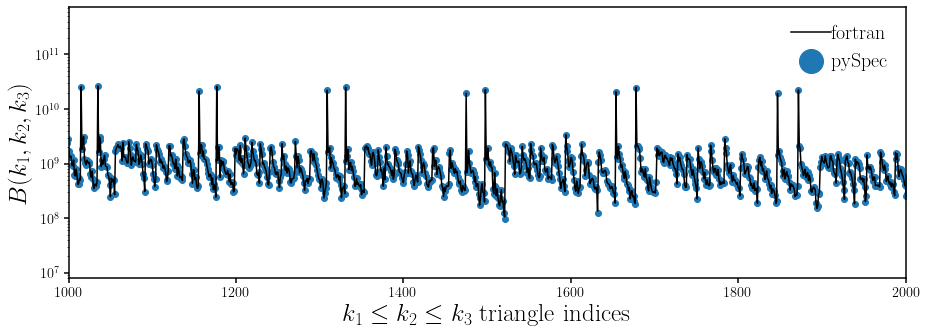

In [109]:
# compare output bispectrum 
i_k, j_k, l_k = bisp['i_k1'], bisp['i_k2'], bisp['i_k3']
klim = ((i_k <= 0.5) & (j_k <= 0.5) & (l_k <= 0.5)) 
print('%i triangle configurations' % np.sum(klim))

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)

sub.plot(range(len(b123_f)), b123_f, c='k', label='fortran') 
sub.scatter(range(np.sum(klim)), bisp['b123'], c='C0', label='pySpec')

sub.legend(loc='upper right', markerscale=4, handletextpad=0., fontsize=20) 
sub.set_ylabel('$B(k_1, k_2, k_3)$', fontsize=25) 
sub.set_yscale('log') 
#sub.set_ylim([1e8, 1e10]) 
sub.set_xlabel(r'$k_1 \le k_2 \le k_3$ triangle indices', fontsize=25) 
sub.set_xlim([1000, 2000])

In [12]:
from scipy.io import FortranFile

coun = pySpec._counts_Bk123()

fcoun = FortranFile(os.path.join(dat_dir, 'counts.fortran'), 'w')
fcoun.write_record(np.asfortranarray(coun))
fcoun.close()

In [ ]:
from scipy.io import FortranFile

f_fft_g = FortranFile(os.path.join(dat_dir, 'fft.gals.lowz.dat'), 'r')
Ngrid = f_fft_g.read_ints(dtype='int32')[0]

_dcg = f_fft_g.read_reals(dtype='float32')
dcg = np.zeros((181, 360, 360), dtype=np.complex)
dcg.real = np.reshape(_dcg[::2], (181, 360, 360), order='F')
dcg.imag = np.reshape(_dcg[1::2], (181, 360, 360), order='F')

I10, I12, I22, I13, I23, I33 = f_fft_g.read_reals(dtype='float32')
P0, Ng, Ngsys, Ngsyscomp = f_fft_g.read_reals(dtype='float32')
print(f_fft_g.read_reals(dtype='float32'))

f_fft_g.close()

f_fft_r = FortranFile(os.path.join(dat_dir, 'fft.rand.lowz.dat'), 'r')
assert Ngrid == f_fft_r.read_ints(dtype='int32')[0]

_dcr = f_fft_r.read_reals(dtype='float32')
#_dcr = np.reshape(__dcr, (362, 360, 360))
dcr = np.zeros((181, 360, 360), dtype=np.complex)
dcr.real = np.reshape(_dcr[::2], (181, 360, 360), order='F')
dcr.imag = np.reshape(_dcr[1::2], (181, 360, 360), order='F')

_ = f_fft_r.read_reals(dtype='float32')
_, Nr, Nrsys, Nrsyscomp, _ = f_fft_r.read_reals(dtype='float32')
print(f_fft_r.read_reals(dtype='float32'))

f_fft_r.close()

dcgk = pySpec.reflect_delta(dcg, Ngrid=Ngrid) 
dcrk = pySpec.reflect_delta(dcr, Ngrid=Ngrid) 

alpha = Ngsys / Nrsys

dck = dcgk - alpha * dcrk

bispec = pySpec._B0_survey(dck, alpha, I12, I13, I22, I23, I33, Nmax=40, Ncut=3,
            step=3, fft='pyfftw', nthreads=1, silent=True)

In [ ]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.scatter(range(len(bispec['b123'])), bispec['b123'], c='C0', s=1, label='pySpec') 
sub.set_ylabel('$B(k_1, k_2, k_3)$', fontsize=25) 
sub.set_yscale('log') 
#sub.set_ylim([1e8, 1e10]) 
sub.set_xlabel(r'$k_1 \le k_2 \le k_3$ triangle indices', fontsize=25) 
sub.set_xlim(0, len(bispec['b123']))